# Variational Autoencoders (VAE)

Based on [`vae/train.py`](https://github.com/google/flax/blob/main/examples/vae/train.py) Flax example. 

Stochastic gradient variational Bayes (SGVB). VLB Monte Carlo estimate

$$
\begin{aligned}
    \hat{\mathcal{L}}(\boldsymbol\theta, \boldsymbol\phi; {\bf X}) &= \sum_{n=1}^N \log p_{\theta_x}({\bf x}_n \vert \hat{\bf z}_n) + \log p_{\theta_z}(\hat{\bf z}_n) - \log p(\hat{\boldsymbol\varepsilon}_n) + \log d_\phi(\hat{\boldsymbol\varepsilon}_n, {\bf x}_n)\\
    &= \sum_{n=1}^N \log\mathcal{N}\left({\bf x}_n \vert \mu_{\theta_x}\left(\hat{\bf z}\right), {\bf I}\sigma^2_{\theta_x}\left(\hat{\bf z}\right)\right) + \sum_{l=1}^L \log\sigma_\phi^2({\bf x}_n)
\end{aligned}
$$

In [788]:
import jax
import optax
import distrax
import jax.numpy as jnp
import flax.linen as nn
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from functools import partial
from flax.training import train_state

In [759]:
%config InlineBackend.figure_format = "retina"

In [760]:
# Taken from jax's website
# https://jax.readthedocs.io/en/latest/notebooks/Neural_Network_and_Data_Loading.html
from torchvision.datasets import MNIST


class FlattenAndCast(object):
  def __call__(self, pic):
    return np.ravel(np.array(pic, dtype=jnp.float32))

root = "/tmp/mnist"
mnist_train = MNIST(root, download=True, train=True)
mnist_test = MNIST(root, download=True, train=False)

In [761]:
X_train = jnp.array(mnist_train.data)
n_train, *_ = X_train.shape
# "Gaussanised" MNIST
Xf_train = X_train.reshape(-1, 28 ** 2)
Xf_train = Xf_train / Xf_train.max()
Xf_train = (Xf_train - Xf_train.mean()) / Xf_train.std()

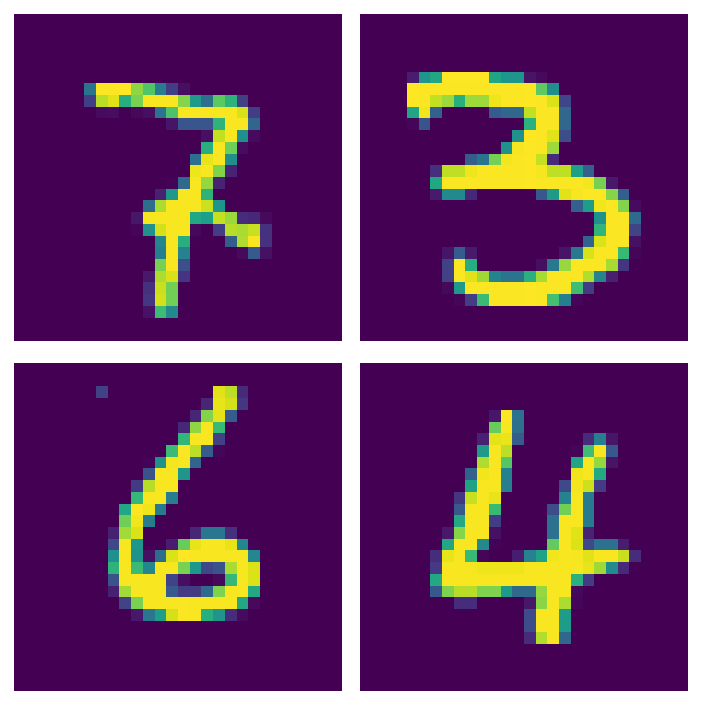

In [762]:
key = jax.random.PRNGKey(314)
key_sample, key = jax.random.split(key)
ixs = jax.random.choice(key, n_train, (4,))

fig, axs = plt.subplots(2, 2, figsize=(5, 5))
axs = axs.ravel()
for ix, ax in zip(ixs, axs):
    ax.imshow(Xf_train[ix].reshape(28, 28))
    ax.axis("off")
plt.tight_layout()

In [763]:
class Encoder(nn.Module):
    """
    For the inference model p(z|x)
    """
    # For the inference model p(z\x)
    latent_dim: int
    
    @nn.compact
    def __call__(self, x):
        z = nn.Dense(100)(x)
        z = nn.relu(z)
        z = nn.Dense(100)(z)
        z = nn.relu(z)
        mean_z = nn.Dense(self.latent_dim)(z)
        logvar_z = nn.Dense(self.latent_dim)(z)
        return mean_z, logvar_z
    
    
class Decoder(nn.Module):
    """
    For the generative model
    p(x,z) = p(x|z) * p(z)
    """
    observed_dim: int
    
    @nn.compact
    def __call__(self, z):
        x = nn.Dense(100)(z)
        x = nn.relu(x)
        x = nn.Dense(100)(x)
        x = nn.relu(x)
        mean_x = nn.Dense(self.observed_dim)(x)
        logvar_x = nn.Dense(self.observed_dim)(x)
        return mean_x, logvar_x


class VAE(nn.Module):
    latent_dim: int
    observed_dim: int
    
    @staticmethod
    def reparameterise(key, mean, logvar):
        std = jnp.exp(logvar / 2)
        eps = jax.random.normal(key, logvar.shape)
        z = mean + eps * std
        return z
    
    def setup(self):
        self.encoder = Encoder(self.latent_dim)
        self.decoder = Decoder(self.observed_dim)
    
    def __call__(self, x, key_eps):
        mean_z, logvar_z = self.encoder(x)
        z = VAE.reparameterise(key_eps, mean_z, logvar_z)
        mean_x, logvar_x = self.decoder(z)
        return (mean_z, logvar_z), (mean_x, logvar_x)

In [829]:
def sgvb(params, model, X_batch, key):
    """
    Loss function
    -------------
    
    Stochastic Gradient Variational Bayes (SGVB)
    estimator.
    """
    encode_decode = model.apply(params, X_batch, key)
    (mean_z, logvar_z), (mean_x, logvar_x) = encode_decode
    
    probx = distrax.Normal(mean_x, jnp.exp(logvar_x / 2))
    
    log_probs_x = probx.log_prob(X_batch).sum(axis=-1)
    elbo_est = log_probs_x + logvar_z.sum()
    return -elbo_est.sum()


def get_batch_train_ixs(key, num_samples, batch_size):
    """
    Obtain the training indices to be used in an epoch of
    mini-batch optimisation.
    """
    steps_per_epoch = num_samples // batch_size
    
    batch_ixs = jax.random.permutation(key, num_samples)
    batch_ixs = batch_ixs[:steps_per_epoch * batch_size]
    batch_ixs = batch_ixs.reshape(steps_per_epoch, batch_size)
    
    return batch_ixs


@jax.jit
def train_step(state, X_batch, key):
    loss_fn = partial(sgvb,
                      model=model, X_batch=X_batch, key=key)
    loss, grads = jax.value_and_grad(loss_fn)(state.params)
    new_state = state.apply_gradients(grads=grads)
    return loss, new_state


def train_epoch(key, state, X, batch_size, epoch):
    num_samples = len(X)
    key_batch, key_vae = jax.random.split(key)
    batch_ixs = get_batch_train_ixs(key_batch, num_samples, batch_size)
    num_batches = len(batch_ixs)
    keys_vae = jax.random.split(key_vae, num_batches)
    
    total_loss = 0
    for key_vae, batch_ix in zip(keys_vae, batch_ixs):
        X_batch = X[batch_ix, ...]
        loss, state = train_step(state, X_batch, key_vae)
        total_loss += loss
    
    return total_loss.item(), state

In [838]:
observed_dim = 28 ** 2
latent_dim = 20
batch_size = 1000
learning_rate = 1e-6
batch_init = jnp.ones((batch_size, observed_dim))

key_params_init, key_eps_init, key_train, key = jax.random.split(key, 4)
model  = VAE(latent_dim, observed_dim)

params_init = model.init(key_params_init, batch_init, key_eps_init)
tx = optax.adam(learning_rate)

state = train_state.TrainState.create(
    apply_fn=model.apply,
    params=params_init,
    tx=tx
)

In [839]:
n_epochs = 200
keys_train = jax.random.split(key_train, n_epochs)

loss_hist = []
for e, key_train in tqdm(enumerate(keys_train), total=len(keys_train)):
    loss, state = train_epoch(key_train, state, Xf_train, batch_size, e)
    loss_hist.append(loss)

  0%|          | 0/200 [00:00<?, ?it/s]

In [840]:
params_final = state.params

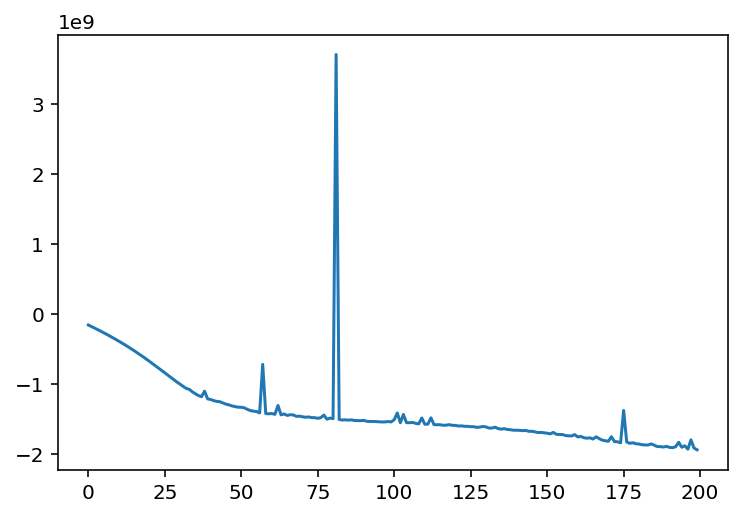

In [841]:
plt.plot(loss_hist)

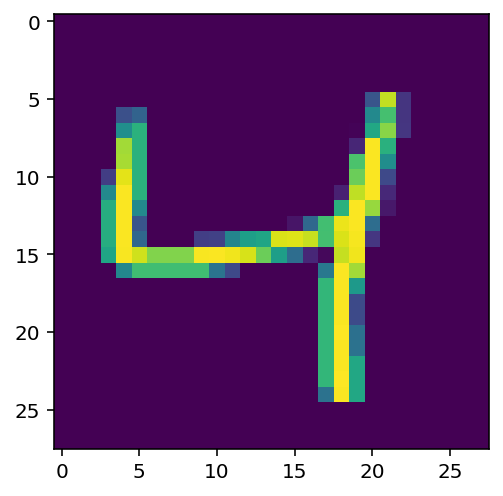

In [845]:
ix = 2
img_test = Xf_train[ix]
plt.imshow(img_test.reshape(28, 28))

In [846]:
_, (mean_rec, logvar_rec) = model.apply(params_final, img_test, key)

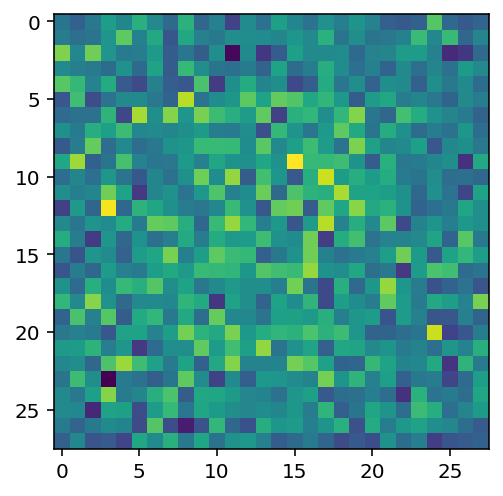

In [847]:
plt.imshow(mean_rec.reshape(28, 28))